# Starbucks Capstone Challenge

### Project Overview

Its Coffee Time! I personally like Starbucks coffee. They offer such a good rewards. But I always wonder, how the these must be working. 

Once in a while Starbuck sent out these offers to their customers on their mobile app. Not to all users though. Different users receive different offers. And, that is the challenge to solve with this dataset. Termination of the offer depends on that specific type of offer.

These tasks depends on number od solds, demographic groups, combined trasactions, etc

## Importing Libraries & loading datasets :

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
%matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Accessing and Cleaning :

### 1. Portfolio Data

#### Dataset column description :

**portfolio.json**

- reward (int) - reward given for completing an offer
- channels (list of strings)
- difficulty (int) - minimum required spend to complete an offer
- duration (int) - time for offer to be open, in days
- offer_type (string) - type of offer ie BOGO, discount, informational
- id (string) - offer id


In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### - Data Cleaning

- convert the column 'Channels' into 4 different channel on the basis of different types of channel .
- rename the column name from 'ID' to 'offer_id' .

In [5]:
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, dummy], axis=1)
portfolio = portfolio.drop(columns='channels')
portfolio = portfolio.rename(columns={'id':'offer_id'})

In [6]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### 2. Profile Data
#### Dataset column description :

**profile.json**

- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- age (int) - age of the customer
- id (str) - customer id
- became_member_on (int) - date when customer created an app account
- income (float) - customer's income

In [47]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


## - Data Cleaning
- convert the datatype of 'became_member_on' column and sort the date into proper format .
- change the column name from 'ID' to 'customer_id' .

In [7]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile = profile.rename(columns={'id':'customer_id'})

In [8]:
profile

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


### 3. Transcript Data
#### Dataset column description :

**transcript.json**

- person (str) - customer id
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- value - (dict of strings) - either an offer id or transaction amount depending on the record
- time (int) - time in hours since start of test. The data begins at time t=0


In [9]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## - Data Cleaning
- change the column name from 'person' to 'customer_id'
- convert the column 'Values' into 2 different column
- convert the column 'Event' into 4 different columns on the basis of different types of event .

In [10]:
transcript = transcript.rename(columns={'person':'customer_id'})
transcript['event'] = transcript['event'].str.replace(' ', '-')
transcript['event'].value_counts()
dummy = pd.get_dummies(transcript['event'])
transcript_ = pd.concat([transcript, dummy], axis=1)

In [11]:
transcript_['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript_['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.value]
transcript_ = transcript_.drop(columns='value')

In [12]:
transcript_

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0,0,0,1,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0,0,0,1,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,0,0,0,1,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0,0,0,1,None,3.53


## - Data Cleaning :

- Concatenate all the three dataset together .
- Fixed the Offer_ids .
- fixed even_ids

In [13]:
temp = pd.merge(transcript_, profile, on='customer_id')
temp

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,75,2017-05-09,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-09-26,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-09-26,NaN
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.0


In [14]:
df = pd.merge(temp, portfolio, on='offer_id', how='left')
df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [15]:
offer_id = df['offer_id'].unique()
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
df['offer_id'] = df['offer_id'].map(offer_dict)
df['offer_id'] = df['offer_id'].replace(1, np.nan)
df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
event_ids = df['event'].unique()
event_dict = pd.Series(event_ids).to_dict()
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
df['event_id'] = df['event'].map(event_dict)
df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,3
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,9.0,NaN,None,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,9.0,NaN,None,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,9.0,NaN,F,...,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,9.0,NaN,F,...,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1


In [63]:
df.to_csv('data/data.csv', index=False)

In [17]:
data = pd.read_csv('data/data.csv')

## Data Exploration and Data Visualization :

In [18]:
data.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

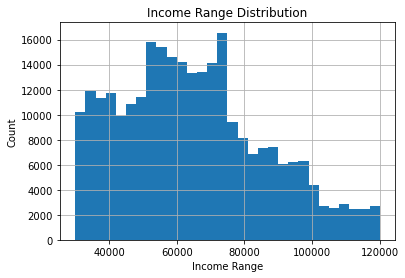

In [19]:
data.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

### Observation :

- Average income user is middle income group ie. 65000-70000 

C:\Users\dhand\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

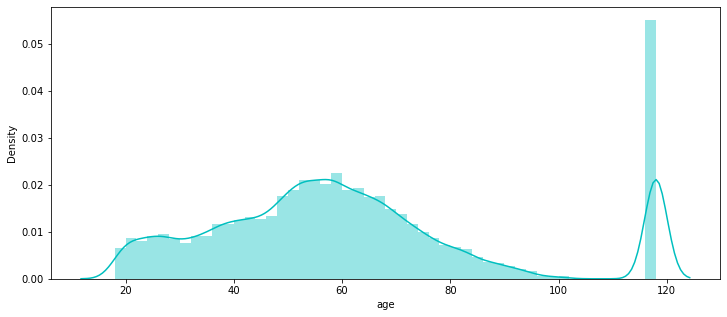

In [20]:
#Distribution Graph 
f= plt.figure(figsize=(12,5))
plt.tight_layout()

sns.distplot(data['age'],color='c')

### Observation :

- Average Aged user is middle age ie. around 50-62 years 
- Outlier is present Age > 115 is present is high amount , which does not make sense .

In [21]:
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()

offer_received , offer_viewed , offer_completed 

(discount         30543
 bogo             30499
 informational    15235
 Name: offer_type, dtype: int64,
 bogo             25449
 discount         21445
 informational    10831
 Name: offer_type, dtype: int64,
 discount    17910
 bogo        15669
 Name: offer_type, dtype: int64)

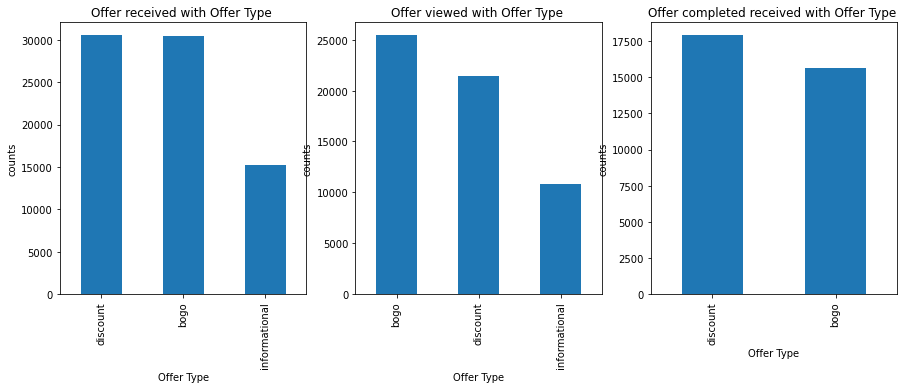

In [22]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');

### Observation :

- Offer with discount and received were high in number

In [23]:
# For BOGO Offer :

Recieved = offer_received[1] 
View = offer_viewed[0] 
Completed = offer_completed[1] 

view_prop = View/Recieved
com_prop = Completed/Recieved
Recieved , View , Completed , view_prop , com_prop

(30499, 25449, 15669, 0.8344208006819895, 0.5137545493294862)

In [24]:
# For DISCOUNT Offer :

Recieved = offer_received[0] 
View = offer_viewed[1] 
Completed = offer_completed[0] 

view_prop = View/Recieved
com_prop = Completed/Recieved
Recieved , View , Completed , view_prop , com_prop

(30543, 21445, 17910, 0.702124873129686, 0.5863864060504862)

### Observation :

- BOGO deals are quite popular, with 30499 individuals receiving a BOGO offer. The offer was viewed by 25449 people, and 15669 people finished it.
- The viewership of the BOGO Offer is 83 percent.
- 70% of viewers are interested in the DISCOUNT Offer.

In [25]:
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()

offer_received , offer_viewed , offer_completed 

(0.0     7677
 5.0     7668
 3.0     7658
 10.0    7646
 7.0     7632
 2.0     7618
 6.0     7617
 8.0     7597
 9.0     7593
 4.0     7571
 Name: offer_id, dtype: int64,
 10.0    7337
 8.0     7327
 9.0     7298
 4.0     7264
 3.0     6716
 2.0     6687
 0.0     4171
 6.0     4144
 7.0     4118
 5.0     2663
 Name: offer_id, dtype: int64,
 8.0     5317
 10.0    5156
 0.0     4354
 4.0     4296
 7.0     4017
 3.0     3688
 5.0     3420
 9.0     3331
 Name: offer_id, dtype: int64)

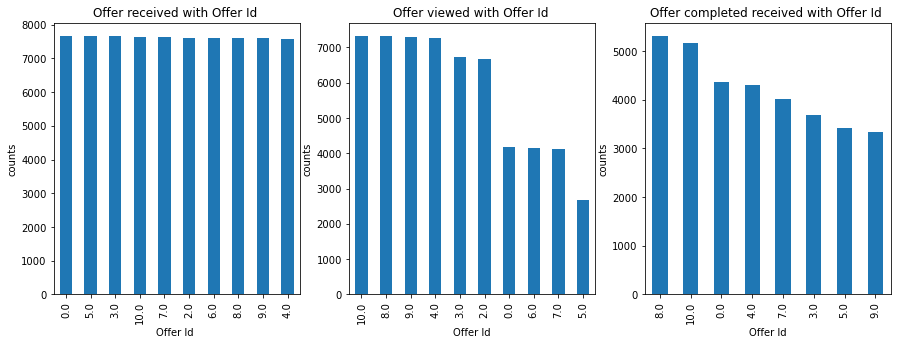

In [26]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id ');

### Observation :

- Each offer id has received individual offers.
- The viewing ratio has fallen for various offer ids, such as 0, 6, 7, and 5. The offer completion ratio is still fairly good.

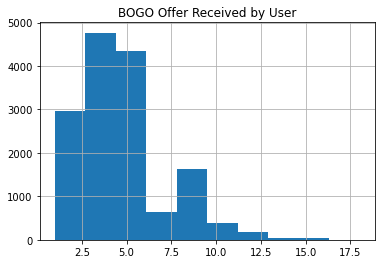

In [29]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count().hist();
plt.title('BOGO Offer Received by User');

### Observation :

- A sizable number of individuals have taken advantage of the BOGO offer.

## Modeling and Predictions :

In [65]:
genders = {'O': 0, 'M': 1, 'F': 2}
data['gender'] = data['gender'].map(genders)

In [66]:
data.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [67]:
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
data['offer_type'] = data['offer_type'].map(offers)

In [68]:
X = data.drop(['customer_id', 'event_id' , 'event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed', 'transaction'], axis=1)
Y = data['event_id']

In [69]:
X.head()

,time,offer_id,amount,gender,age,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0,0.0,NaN,2.0,75,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0
1,6,0.0,NaN,2.0,75,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0
2,132,NaN,19.89,2.0,75,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132,0.0,NaN,2.0,75,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0
4,144,NaN,17.78,2.0,75,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
Y.head()

0    0
1    1
2    2
3    3
4    2
Name: event_id, dtype: int64

In [71]:
X.shape , Y.shape

((306534, 14), (306534,))

### Feature Scaling : 

#### Standardization & Normalization

Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

- let's create a new X dataframe with highly dependent features .
- also adding more hidden layers .
- also adding hidden units .

In [88]:
data.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [89]:
X = data.drop(['customer_id', 'event_id' ,  'amount','event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed','email', 'mobile', 'social', 'web', 'time','transaction', 'duration'], axis=1)
Y = data['event_id']

In [90]:
X.shape , Y.shape

((306534, 7), (306534,))

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [92]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214573, 7), (91961, 7), (214573,), (91961,))

In [93]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

C:\Users\dhand\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\dhand\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [94]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

C:\Users\dhand\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\dhand\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# 1. XGBoost Model
Let us first try a simple but powerful machine learning model.

In [153]:
import xgboost as xbg
from copy import deepcopy
from sklearn.model_selection import train_test_split

In [155]:
dtrain=xbg.DMatrix(X_train, y_train)
dtest=xbg.DMatrix(X_test, y_test)

In [159]:
#training without monotonic constrains
evals  = [(dtrain, 'train'), (dtest, 'eval')]

params_no_constraint = {
    'nthread': 6,
    'seed': 0,
    'eval_metric': 'mae',
    'eta': 0.1,
    'max_depth': 3
}
evals_result = {}
model = xbg.train(
    params_no_constraint, dtrain,
    evals=evals,
    evals_result=evals_result,
    num_boost_round=50,
    verbose_eval=1)

[0]	train-mae:1.10047	eval-mae:1.10027
[1]	train-mae:1.03532	eval-mae:1.03581
[2]	train-mae:0.97694	eval-mae:0.97801
[3]	train-mae:0.92423	eval-mae:0.92577
[4]	train-mae:0.87653	eval-mae:0.87882
[5]	train-mae:0.83391	eval-mae:0.83640
[6]	train-mae:0.79552	eval-mae:0.79847
[7]	train-mae:0.76108	eval-mae:0.76408
[8]	train-mae:0.73001	eval-mae:0.73287
[9]	train-mae:0.70197	eval-mae:0.70522
[10]	train-mae:0.67665	eval-mae:0.68027
[11]	train-mae:0.65403	eval-mae:0.65762
[12]	train-mae:0.63338	eval-mae:0.63730
[13]	train-mae:0.61514	eval-mae:0.61917
[14]	train-mae:0.59954	eval-mae:0.60452
[15]	train-mae:0.58574	eval-mae:0.59251
[16]	train-mae:0.57405	eval-mae:0.58288
[17]	train-mae:0.56401	eval-mae:0.57478
[18]	train-mae:0.55479	eval-mae:0.56679
[19]	train-mae:0.54651	eval-mae:0.55936
[20]	train-mae:0.53918	eval-mae:0.55359
[21]	train-mae:0.53254	eval-mae:0.54844
[22]	train-mae:0.52646	eval-mae:0.54302
[23]	train-mae:0.52120	eval-mae:0.53782
[24]	train-mae:0.51641	eval-mae:0.53347
[25]	train

In [160]:
from sklearn.metrics import r2_score

print("\nTest  R2 Score : %.2f"%r2_score(y_test, model.predict(dtest)))
print("Train R2 Score : %.2f"%r2_score(y_train, model.predict(dtrain)))


Test  R2 Score : 0.32
Train R2 Score : 0.34


As it can be observed, there is not a good score for the xgboost model.

In [95]:
# Convert the pandas dataframe into numpy array

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# 2. ANN Model
Now let us try a simple ANN deep learning model. 

In [115]:
ann = keras.models.Sequential()

In [116]:
ann.add(keras.layers.Dense(32, input_dim=7,activation='relu'))
ann.add(keras.layers.Dense(15,activation='relu'))
ann.add(keras.layers.Dense(10,activation='relu'))
ann.add(keras.layers.Dense(6,activation='relu'))
ann.add(keras.layers.Dense(4,,activation = 'softmax'))

In [117]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [118]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100 , verbose = 2)

Epoch 1/15
2146/2146 - 2s - loss: nan - accuracy: 0.2480 - val_loss: nan - val_accuracy: 0.2507
Epoch 2/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 3/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 4/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 5/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 6/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 7/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 8/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 9/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 10/15
2146/2146 - 2s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 11/15
2146/2146 - 2s - loss: nan 

In [119]:
ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 15)                495       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 28        
Total params: 1,005
Trainable params: 1,005
Non-trainable params: 0
_________________________________________________________________


In [120]:
ann.history.params

{'verbose': 2, 'epochs': 15, 'steps': 2146}

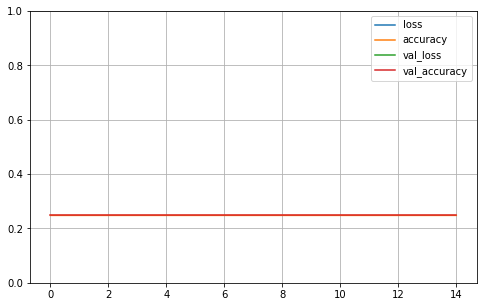

In [121]:
pd.DataFrame(ann.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

### Evaluation Martrix :

- evaluation can be done on the basis of accuracy obtained by the model and by Loss produced .

In [122]:
ann.evaluate(X_test , y_test)

2874/2874 [==============================] - 2s 558us/step - loss: nan - accuracy: 0.2507


[nan, 0.25066059827804565]

## Observation :

- the accuracy is very less.
- the events are wrongly predicted as 'offer received'

# Conclusion :

- The structure of the data in the transcript dataset is fairly vast. This makes the problem statement challenging.
- I tried both machine learning and deep learning model.
- There lies a problem of imbalanced dataset. Majority classes are performing well but the minorities are not. 
- 'offer received' events ate wrongly predicted most of the times


# potential improvement
 
 - But the results of the model does not seems so good . For both the models there is not much difference between the accuracy improvements. 
 - The results can be further imporoved if more experiments tried on different model dataset and feature scaling.

# References : 

- https://xgboost.readthedocs.io/en/latest/
- https://seaborn.pydata.org/generated/seaborn.distplot.html
- https://seaborn.pydata.org/generated/seaborn.displot.html
- https://seaborn.pydata.org/tutorial/distributions.html
- https://www.geeksforgeeks.org/ml-feature-scaling-part-2/#:~:text=Feature%20Scaling%20is%20a%20technique,data%20in%20a%20fixed%20range.&text=If%20feature%20scaling%20is%20not,the%20unit%20of%20the%20values.
- https://towardsdatascience.com/building-your-own-artificial-neural-network-from-scratch-on-churn-modeling-dataset-using-keras-in-690782f7d051

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])